<a href="https://colab.research.google.com/github/tejash2005/first_github_repo/blob/main/data_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#  Replace 'your_file.csv' with the correct path to your CSV file
file_path = '/content/drive/My Drive/Online Retail.csv'

# Load the CSV file
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Customer Segmentation

**data preprocess**

In [19]:
# Step 1: Remove Missing CustomerID
df_clean = df.dropna(subset=['CustomerID'])

# Step 2: Remove Cancelled Transactions (InvoiceNo starting with 'C')
df_clean = df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

# Step 3: Remove Negative or Zero Quantity and UnitPrice
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Step 4: Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], dayfirst=True)


# Step 5: Convert CustomerID to string
df_clean['CustomerID'] = df_clean['CustomerID'].astype(str)

# Step 6: Final Check
print("Shape after cleaning:", df_clean.shape)
print("Missing Values:\n", df_clean.isnull().sum())
print("Sample Cleaned Data:\n", df_clean.head())


Shape after cleaning: (397884, 8)
Missing Values:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Sample Cleaned Data:
   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice CustomerID         Country  
0 2010-12-01 08:26:00       2.55    17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75    17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39    17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39   

In [20]:
# Step 1: Create a Snapshot Date (usually 1 day after the last InvoiceDate)
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot Date:", snapshot_date)

# Step 2: Group by CustomerID and Calculate R, F, M
rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency (number of invoices)
    'UnitPrice': 'sum'                                        # Monetary (total amount spent)
})

# Step 3: Rename the Columns
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
}, inplace=True)

# Step 4: Check the RFM Table
print("RFM Table Shape:", rfm.shape)
print(rfm.head())


Snapshot Date: 2011-12-10 12:50:00
RFM Table Shape: (4338, 3)
            Recency  Frequency  Monetary
CustomerID                              
12346.0         326          1      1.04
12347.0           2          7    481.21
12348.0          75          4    178.71
12349.0          19          1    605.10
12350.0         310          1     65.30


In [21]:
# Step 1: Save Cleaned Dataset
df_clean.to_csv('cleaned_retail_data.csv', index=False)
print("Cleaned retail dataset saved as 'cleaned_retail_data.csv'")

# Step 2: Save RFM Table
rfm.to_csv('rfm_table.csv')
print("RFM table saved as 'rfm_table.csv'")


Cleaned retail dataset saved as 'cleaned_retail_data.csv'
RFM table saved as 'rfm_table.csv'


 **Scaling RFM Data**

In [22]:
from sklearn.preprocessing import StandardScaler

# Load RFM again if needed
rfm = pd.read_csv('rfm_table.csv', index_col=0)

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

print("RFM data scaled successfully.")


RFM data scaled successfully.


**Train MiniBatch KMeans**

In [23]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(
    n_clusters=10,      # adjust as needed
    random_state=42,
    batch_size=5000,
    max_iter=500
)

kmeans.fit(rfm_scaled)

# Add cluster labels to RFM table
rfm['Cluster'] = kmeans.labels_

print("Clusters assigned:")
print(rfm['Cluster'].value_counts().sort_index())


Clusters assigned:
Cluster
0     515
1    1212
2     313
3      25
4     188
5     357
6     253
7     360
8     713
9     402
Name: count, dtype: int64


In [24]:
import joblib

# Save model and scaler for later use
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print(" Model and Scaler saved successfully.")


 Model and Scaler saved successfully.


In [25]:
# Load model and scaler (later when needed)
kmeans = joblib.load('kmeans_model.pkl')
scaler = joblib.load('scaler.pkl')

def predict_customer_segment(recency, frequency, monetary):
    """
    Predict customer segment for new input data
    """
    customer_data = [[recency, frequency, monetary]]
    customer_scaled = scaler.transform(customer_data)
    cluster = kmeans.predict(customer_scaled)
    return int(cluster[0])

In [26]:
import joblib
import pandas as pd
import numpy as np

# Load model and scaler (ensure the path to your files is correct)
kmeans = joblib.load('kmeans_model.pkl')
scaler = joblib.load('scaler.pkl')

def predict_customer_segment(recency, frequency, monetary):
    # Validate input
    if recency < 0 or frequency < 0 or monetary < 0:
        raise ValueError("Recency, Frequency, and Monetary values must be non-negative.")

    # Create a DataFrame with the exact feature names used during training
    customer_data = pd.DataFrame([[recency, frequency, monetary]], columns=['Recency', 'Frequency', 'Monetary'])

    # Ensure scaler and kmeans model are loaded
    try:
        customer_scaled = scaler.transform(customer_data)
        cluster = kmeans.predict(customer_scaled)
        return int(cluster[0])
    except Exception as e:
        raise RuntimeError(f"Error during prediction: {e}")

# Example usage:
try:
    # Example customer data
    customer_segment = predict_customer_segment(46, 9, 265)
    print(f"The customer belongs to segment: {customer_segment}")
except ValueError as ve:
    print(f"Input error: {ve}")
except RuntimeError as re:
    print(f"Prediction error: {re}")


The customer belongs to segment: 8


In [27]:
import joblib
import pandas as pd

# Load trained scaler & model
scaler = joblib.load('scaler.pkl')
kmeans = joblib.load('kmeans_model.pkl')

def predict_customer_segment(recency, frequency, monetary):
    """
    Predicts cluster for a new customer's RFM values.
    """
    customer_data = pd.DataFrame(
        [[recency, frequency, monetary]],
        columns=['Recency', 'Frequency', 'Monetary']
    )
    scaled = scaler.transform(customer_data)
    cluster = kmeans.predict(scaled)
    return int(cluster[0])

# Example for a new customer:
print("Predicted segment:", predict_customer_segment(15, 4, 350))


Predicted segment: 8


In [28]:
from sklearn.metrics import silhouette_score

# Compute silhouette score on the scaled data
score = silhouette_score(rfm_scaled, kmeans.labels_)
print(f"Silhouette Score: {score:.4f}")


Silhouette Score: 0.3085


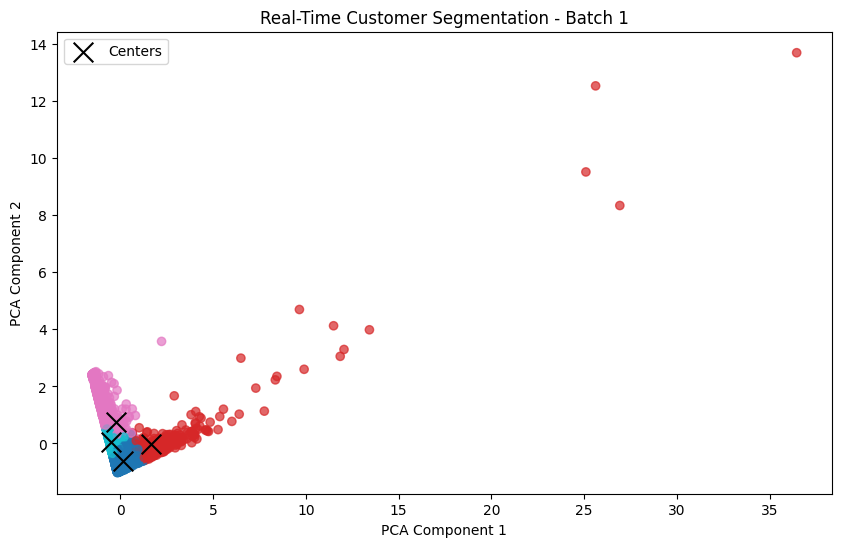

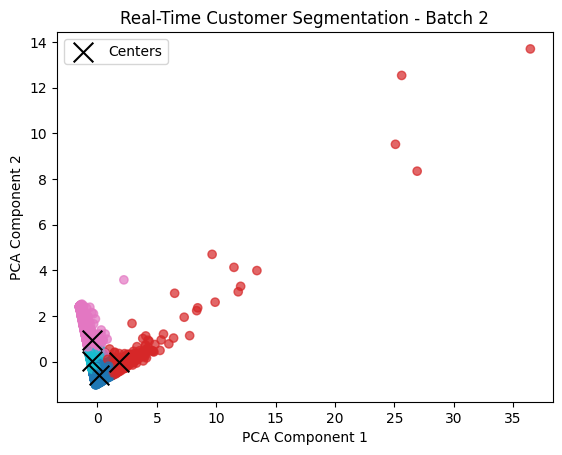

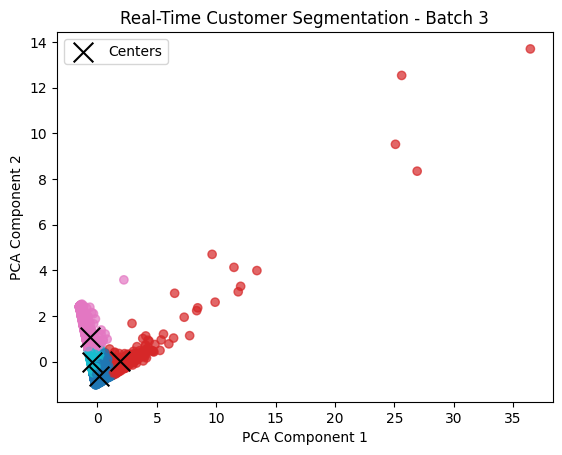

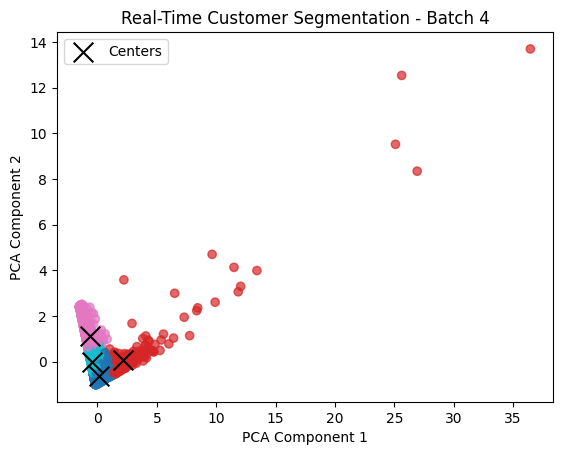

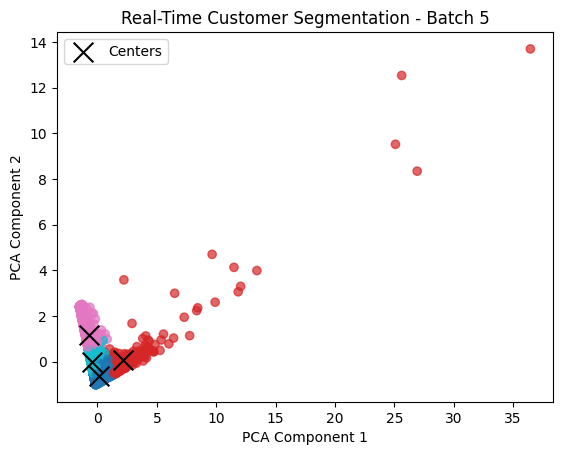

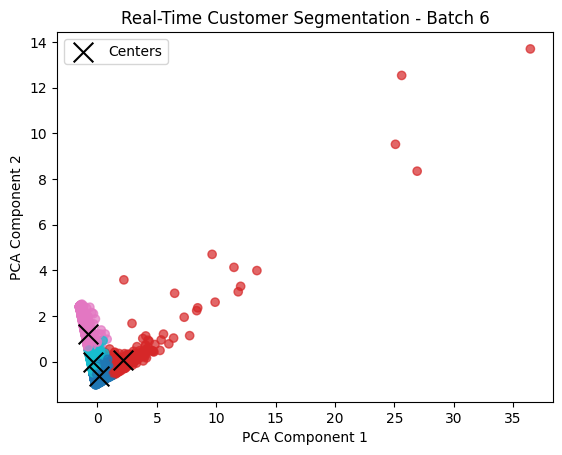

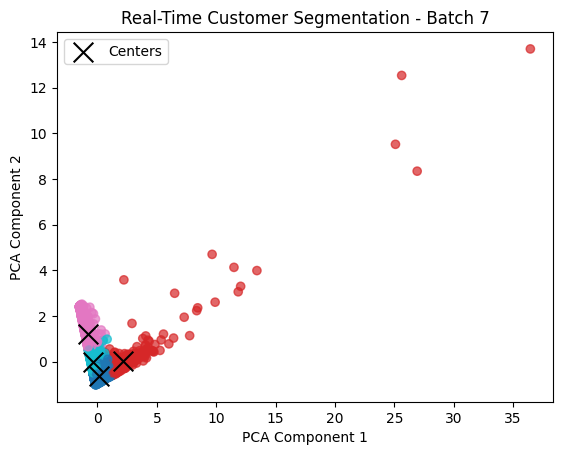

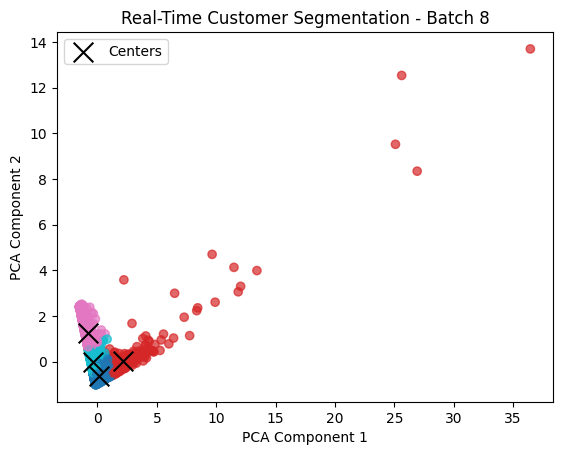

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

# Simulated Streaming: Load RFM data
rfm_data = pd.read_csv('rfm_table.csv')  # Replace with your file
features = ['Recency', 'Frequency', 'Monetary']

# Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_data[features])

# Simulate Real-time Stream
batch_size = 500
num_clusters = 4
mbkm = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size, random_state=42)

# For Visualization: Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Simulate streaming and plot updates
plt.figure(figsize=(10, 6))
for i in range(0, len(X_scaled), batch_size):
    batch = X_scaled[i:i+batch_size]
    if len(batch) < batch_size:
        break
    mbkm.partial_fit(batch)
    labels = mbkm.predict(X_scaled)

    # Plot clusters in 2D PCA space
    plt.clf()
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
    centers = pca.transform(mbkm.cluster_centers_)
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, marker='x', label='Centers')
    plt.title(f'Real-Time Customer Segmentation - Batch {i//batch_size + 1}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.pause(0.8)  # Use plt.pause for animated updates

plt.show()


# Anomaly Detection

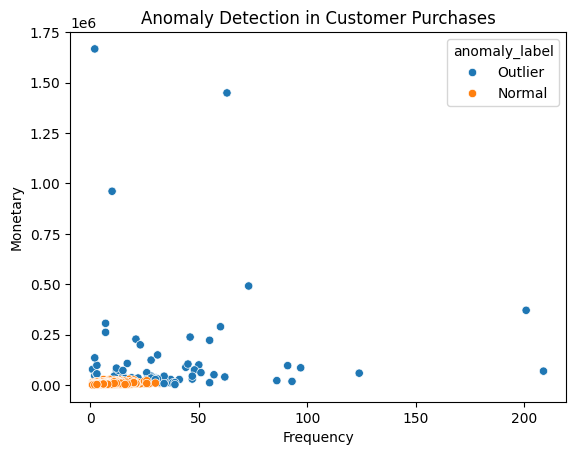

Total anomalies found: 87


,CustomerID,Recency,Frequency,Monetary,anomaly,anomaly_label
0,12346.0,326,1,77183.600000,-1,Outlier
55,12415.0,24,21,227254.156751,-1,Outlier
100,12471.0,2,30,35314.634870,-1,Outlier
152,12536.0,43,3,97416.922567,-1,Outlier
196,12590.0,211,2,45174.312647,-1,Outlier


In [30]:
# Step 1: Imports
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load your cleaned dataset
df = pd.read_csv('cleaned_retail_data.csv')

# Step 3: Prepare RFM or relevant features
# We'll use RFM here
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'UnitPrice': 'mean'
}).reset_index()

rfm['Monetary'] = rfm['Quantity'] * rfm['UnitPrice']
rfm.drop(['Quantity', 'UnitPrice'], axis=1, inplace=True)
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm = rfm.dropna()


# Step 4: Isolation Forest
model = IsolationForest(contamination=0.02, random_state=42)
rfm['anomaly'] = model.fit_predict(rfm[['Recency', 'Frequency', 'Monetary']])

# Step 5: Label interpretation
# anomaly = -1 → outlier, 1 → normal
rfm['anomaly_label'] = rfm['anomaly'].apply(lambda x: 'Outlier' if x == -1 else 'Normal')

# Step 6: Visualize
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='anomaly_label')
plt.title('Anomaly Detection in Customer Purchases')
plt.show()

# Step 7: Show Outliers
outliers = rfm[rfm['anomaly_label'] == 'Outlier']
print(f"Total anomalies found: {len(outliers)}")
outliers.head()


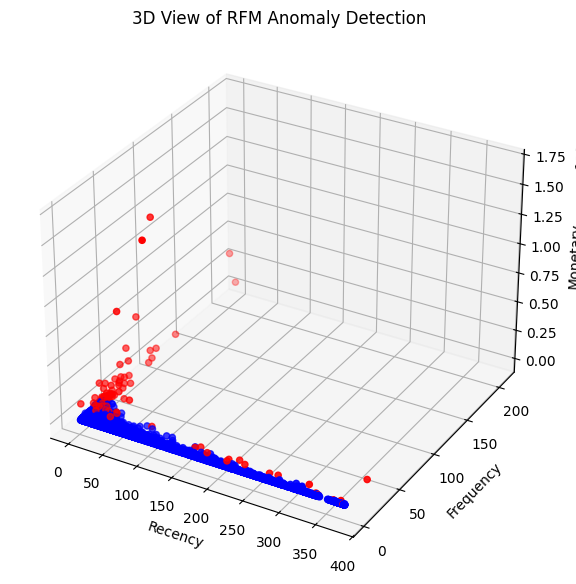

In [31]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = rfm['anomaly_label'].map({'Normal': 'blue', 'Outlier': 'red'})

ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'], c=colors)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D View of RFM Anomaly Detection')
plt.show()
